# The Typical Section

Initialise by clicking "restart" in the toolbar above (button with ">>" symbol: Restart the kernel and run all cells)

In [1]:
# Enable interactive plots in JupyterLab
%matplotlib widget

# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as wgt
import numpy as np
import math
from IPython.display import display, Markdown
import textwrap
import copy

# This acts like a function allowing the creation of "struct-like" objects
class defineStruct:
    pass

# Important function for creating slider copies
def copySlider(original):

    cls = type(original)
    
    # Create a new layout object with same properties
    new_layout = wgt.Layout(
        width=original.layout.width,
        height=original.layout.height,
        grid_area=original.layout.grid_area,
        min_width=original.layout.min_width,
        min_height=original.layout.min_height,
        max_width=original.layout.max_width,
        max_height=original.layout.max_height,
    )
    
    # Create the cloned slider
    clone = cls(
        value=original.value,
        min=original.min,
        max=original.max,
        step=original.step,
        description=original.description,
        readout=original.readout,
        orientation=original.orientation,
        layout=new_layout,
        style=original.style,  # safe to share
    )
    
    # Link value to the original
    link = wgt.link((original, 'value'), (clone, 'value'))
    
    return clone, link

# Import NACA0012 profile coordinates (suction side only)
airfoilData = pd.read_csv('NACA0012_suctionSide.csv').to_numpy(dtype = float)

## Typical Section Geometry

In [2]:
# Generate the plot
plt.ioff()
fig, ax = plt.subplots(figsize = (8, 4));
ax.axis("equal"); ax.axis("off");

# Plot skins
ax.plot(airfoilData[:, 0], airfoilData[:, 1], color = 'black'); # suction side skin
ax.plot(airfoilData[:, 0], -airfoilData[:, 1], color = 'black'); # pressure side skin

# Plot auxiliary lines
# plt.plot(np.array([0, 0]), 0.3*np.array([1, -1]), color = 'black', linewidth = 0.5) # leading edge line
# plt.plot(np.array([1, 1]), 0.3*np.array([1, -1]), color = 'black', linewidth = 0.5) # trailing edge line
ax.plot(np.array([0.5, 0.5]), 0.3*np.array([1, -1]), color = 'black', linewidth = 0.5, linestyle = '--'); # mid-chord line

# Plot aerodynamic centre
ax.plot(0.25*np.array([1, 1]), 0.10*np.array([0, 1]), color = 'black', linewidth = 0.5);
p_ac = ax.scatter(0.25, 0, s = 40, c = 'black', marker = 'x');
ax.plot(np.array([0.25, 0.5]), 0.09*np.array([1, 1]), color = 'black', linewidth = 0.5);
ax.text(3*0.25/2, 0.11, str(f"{-2*0.25:.2f}"), ha = 'center', va = 'center');

In [3]:
# Set initial values, to get default graph
a = -0.2; cg_a = 0.15; c =  0.4; cg_f = 0.55;

x_th = cg_a - a; x_b = cg_f - c;

def getFlapData(c):

    # Distance between hinge line and points on the skin
    hingeDist = airfoilData - np.array([c/2 + 0.5, 0]) # distance vectors
    hingeDist = np.linalg.norm(hingeDist, axis = 1) # distance magnitude
    
    ind_minDist = np.argmin(hingeDist) # index of nearest skin point
    minDist = hingeDist[ind_minDist] # distance to nearest skin point
    minPoint = airfoilData[ind_minDist, :] # nearest point coordinates
    
    # Get circle segment representing the front end of the flap
    segAng = np.pi - math.atan2(minPoint[1], minPoint[0] - (c/2 + 0.5)) # angle between negative x-axis and nearest skin point
    arr_segAng = np.linspace(0, segAng, 20).reshape(20, 1)
    
    x_frontFlap = -minDist*np.cos(arr_segAng) + (c/2 + 0.5)
    y_frontFlap = minDist*np.sin(arr_segAng)
    
    frontFlapData = np.hstack((np.vstack((x_frontFlap[::-1], x_frontFlap[1:])),
                               np.vstack((-y_frontFlap[::-1], y_frontFlap[1:]))))

    return frontFlapData

# Plot flap
frontFlapData = getFlapData(c)
line_flap, = ax.plot(frontFlapData[:, 0], frontFlapData[:, 1], color = 'black');

In [4]:
# Elastic axis
vLine_a, = ax.plot((a/2 + 0.5)*np.array([1, 1]), 0.16*np.array([0, 1]), color = 'blue', linewidth = 0.5);
p_a = ax.scatter(a/2 + 0.5, 0, s = 40, c = 'blue', marker = 'o', edgecolor = 'black');
hLine_a, = ax.plot(np.array([a/2 + 0.5, 0.5]), 0.15*np.array([1, 1]), color = 'blue', linewidth = 0.5);
txt_a = ax.text(0.5 + a/4, 0.17, str(f"{a:.2f}"), ha = 'center', va = 'center', color = 'blue');

# Centre of gravity - airfoil
vLine_CGa, = ax.plot((cg_a/2 + 0.5)*np.array([1, 1]), 0.22*np.array([0, 1]), color = 'blue', linewidth = 0.5);
p_CGa = ax.scatter(cg_a/2 + 0.5, 0, s = 40, c = 'blue', marker = 'D', edgecolor = 'black');
hLine_CGa, = ax.plot(np.array([cg_a/2 + 0.5, 0.5]), 0.21*np.array([1, 1]), color = 'blue', linewidth = 0.5);
txt_CGa = ax.text(0.5 + cg_a/4, 0.23, str(f"{cg_a:.2f}"), ha = 'center', va = 'center', color = 'blue');

# x_theta
arr_xth = np.array([a/2 + 0.5, cg_a/2 + 0.5])
vLine_xth_a, =  ax.plot(arr_xth[0]*np.array([1, 1]), np.array([0.16, 0.28]), color = 'blue', linewidth = 0.5, linestyle = '--');
vLine_xth_CGa, =  ax.plot(arr_xth[1]*np.array([1, 1]), np.array([0.22, 0.28]), color = 'blue', linewidth = 0.5, linestyle = '--');
hLine_xth, = ax.plot(arr_xth, 0.27*np.array([1, 1]), color = 'blue', linewidth = 0.5, linestyle = '--');
txt_xth = ax.text(np.mean(arr_xth), 0.29, "$x_{\\theta}$ = " + f"{x_th:.2f}", ha = 'center', va = 'center', color = 'blue');

# Flap hinge axis
vLine_c, = ax.plot((c/2 + 0.5)*np.array([1, 1]), -0.16*np.array([0, 1]), color = 'red', linewidth = 0.5);
p_c = ax.scatter(c/2 + 0.5, 0, s = 40, c = 'red', marker = 'o', edgecolor = 'black');
hLine_c, = ax.plot(np.array([c/2 + 0.5, 0.5]), -0.15*np.array([1, 1]), color = 'red', linewidth = 0.5);
txt_c = ax.text(0.5 + c/4, -0.17, str(f"{c:.2f}"), ha = 'center', va = 'center', color = 'red');

# Centre of gravity - flap
vLine_CGf, = ax.plot((cg_f/2 + 0.5)*np.array([1, 1]), -0.22*np.array([0, 1]), color = 'red', linewidth = 0.5);
p_CGf = ax.scatter(cg_f/2 + 0.5, 0, s = 40, c = 'red', marker = 'D', edgecolor = 'black');
hLine_CGf, = ax.plot(np.array([cg_f/2 + 0.5, 0.5]), -0.21*np.array([1, 1]), color = 'red', linewidth = 0.5);
txt_CGf = ax.text(0.5 + cg_f/4, -0.23, str(f"{cg_f:.2f}"), ha = 'center', va = 'center', color = 'red');

# x_beta
arr_xb = np.array([c/2 + 0.5, cg_f/2 + 0.5])
vLine_xb_c, =  ax.plot(arr_xb[0]*np.array([1, 1]), -np.array([0.16, 0.28]), color = 'red', linewidth = 0.5, linestyle = '--');
vLine_xb_CGf, =  ax.plot(arr_xb[1]*np.array([1, 1]), -np.array([0.22, 0.28]), color = 'red', linewidth = 0.5, linestyle = '--');
hLine_xb, = ax.plot(arr_xb, -0.27*np.array([1, 1]), color = 'red', linewidth = 0.5, linestyle = '--');
txt_xb = ax.text(np.mean(arr_xb), -0.29, "$x_{\\beta}$ = " + f"{x_b:.2f}", ha = 'center', va = 'center', color = 'red');

ax.legend([p_ac, p_a, p_CGa, p_c, p_CGf], ["Aero. Centre", "Elastic Axis", "C.G. Airfoil", "Flap Hinge Axis", "C.G. Flap"],
           loc = 'center left', bbox_to_anchor = (1, 0.5));

In [5]:
def updatePoints(x, vLine, p, hLine, txt):

    # Start with vertical line
    vLine.set_xdata((x/2 + 0.5)*np.array([1, 1]))
    vLine.figure.canvas.draw_idle()

    # Update scatter point
    p.set_offsets(np.c_[x/2 + 0.5, 0])
    p.figure.canvas.draw_idle()

    # Update horizontal line
    hLine.set_xdata([x/2 + 0.5, 0.5])
    hLine.figure.canvas.draw_idle()

    # Finally update the text string as well as position
    txt.set_x(0.5 + x/4)
    txt.set_text(str(f"{x: .2f}"))
    txt.figure.canvas.draw_idle()

def updateDist(x1, x2, vLine_1, vLine_2, hLine, txt, str_symbol):

    arr_x = np.array([x1/2 + 0.5, x2/2 + 0.5])
    
    # Start with first vertical line, corresponding to ref point
    vLine_1.set_xdata(arr_x[0]*np.array([1, 1]))
    vLine_1.figure.canvas.draw_idle()

    # Then adapt the second vertical line, corresponding to CG point
    vLine_2.set_xdata(arr_x[1]*np.array([1, 1]))
    vLine_2.figure.canvas.draw_idle()

    # Update horizontal line
    hLine.set_xdata(arr_x)
    hLine.figure.canvas.draw_idle()

    # Finally update the text string as well as position
    x_dist = x2 - x1
    txt.set_x(np.mean(arr_x))
    txt.set_text(str_symbol + " = " + f"{x_dist:.2f}")
    txt.figure.canvas.draw_idle()
    

In [6]:
def updateTypSection(a, cg_a, c, cg_f):

    # Front flap line
    frontFlapData = getFlapData(c)
    line_flap.set_xdata(frontFlapData[:, 0])
    line_flap.set_ydata(frontFlapData[:, 1])
    line_flap.figure.canvas.draw_idle()

    # The four variable points
    updatePoints(a, vLine_a, p_a, hLine_a, txt_a) # elastic axis
    updatePoints(cg_a, vLine_CGa, p_CGa, hLine_CGa, txt_CGa) # C.G. airfoil
    updatePoints(c, vLine_c, p_c, hLine_c, txt_c) # hinged flap axis
    updatePoints(cg_f, vLine_CGf, p_CGf, hLine_CGf, txt_CGf) # C.G. flap

    # The two distances, x_theta and x_beta
    updateDist(a, cg_a, vLine_xth_a, vLine_xth_CGa, hLine_xth, txt_xth, "$x_{\\theta}$") # x_theta
    updateDist(c, cg_f, vLine_xb_c, vLine_xb_CGf, hLine_xb, txt_xb, "$x_{\\beta}$") # x_beta

def updateTypSection_v2(change):

    # Adapt variables based on sliders
    a = slider_a.value
    cg_a = slider_CGa.value
    c = slider_c.value
    cg_f = slider_CGf.value
    
    # Front flap line
    frontFlapData = getFlapData(c)
    line_flap.set_xdata(frontFlapData[:, 0])
    line_flap.set_ydata(frontFlapData[:, 1])
    line_flap.figure.canvas.draw_idle()

    # The four variable points
    updatePoints(a, vLine_a, p_a, hLine_a, txt_a) # elastic axis
    updatePoints(cg_a, vLine_CGa, p_CGa, hLine_CGa, txt_CGa) # C.G. airfoil
    updatePoints(c, vLine_c, p_c, hLine_c, txt_c) # hinged flap axis
    updatePoints(cg_f, vLine_CGf, p_CGf, hLine_CGf, txt_CGf) # C.G. flap

    # The two distances, x_theta and x_beta
    updateDist(a, cg_a, vLine_xth_a, vLine_xth_CGa, hLine_xth, txt_xth, "$x_{\\theta}$") # x_theta
    updateDist(c, cg_f, vLine_xb_c, vLine_xb_CGf, hLine_xb, txt_xb, "$x_{\\beta}$") # x_beta
    

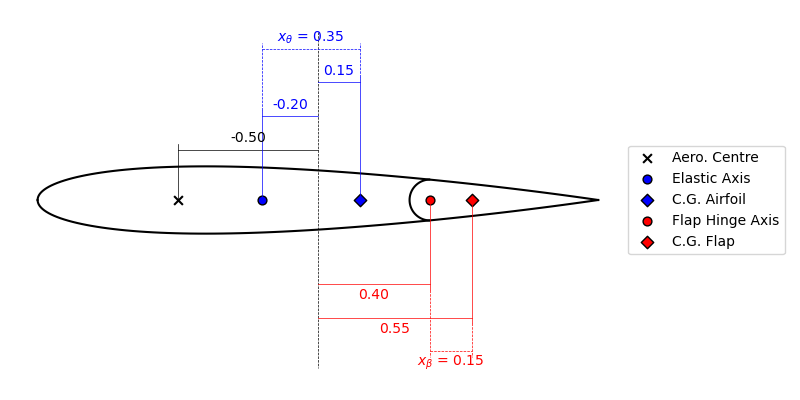

GridspecLayout(children=(FloatSlider(value=-0.3, description='$\\alpha$', layout=Layout(grid_area='widget001',…

In [7]:
# Start by plotting graph
fig.tight_layout();
plt.show()

# Customise sliders
stepSize = 0.01
descrWidth = '120px'
sliderWidth = '450px'

# Define sliders
slider_a = wgt.FloatSlider(value = -0.3, min = -0.9, max = 0.9, step = 0.01, 
                           description = '$\\alpha$', style = {'description_width': descrWidth},
                           layout = wgt.Layout(width = sliderWidth))
slider_CGa = wgt.FloatSlider(value = 0.15, min = -0.9, max = 0.9, step = 0.01, 
                             description = '$CG_{a}$', style = {'description_width': descrWidth},
                             layout = wgt.Layout(width = sliderWidth))
slider_c = wgt.FloatSlider(value = 0.3, min = -0.9, max = 0.9, step = 0.01,
                           description = '$c$', style = {'description_width': descrWidth},
                           layout = wgt.Layout(width = sliderWidth))
slider_CGf = wgt.FloatSlider(value = 0.55, min = -0.9, max = 0.9, step = 0.01, 
                             description = '$CG_{f}$', style = {'description_width': descrWidth},
                             layout = wgt.Layout(width = sliderWidth))

listSliders1 = [slider_a, slider_CGa, slider_c, slider_CGf]

# Link sliders with update function
for s in listSliders1:
    s.observe(updateTypSection_v2, names = 'value')

# Display sliders in two columns
gridSliders1 = wgt.GridspecLayout(2, 2, layout = wgt.Layout(width = '1000px'))

gridSliders1[0, 0] = slider_a
gridSliders1[1, 0] = slider_CGa
gridSliders1[0, 1] = slider_c
gridSliders1[1, 1] = slider_CGf

display(gridSliders1)

## Mass and Stiffness Matrix

In [8]:
# Initialise the global variables
mat_strMass = None
mat_strStiff = None

# Define a function that takes the slider values and calculates the mass and stiffness matrix
def strMatrices(a, cg_a, c, cg_f, b, ma, mf, Iaf_CGa, If_CGf, Kh, Kth, Kb):

    # Calculate key terms based on slider values
    x_th = cg_a - a
    x_b = cg_f - c

    m_tot = ma + mf
    S_th = (ma*x_th + mf*(c - a +x_b))*b
    S_b = mf*x_b*b

    Iaf_a = Iaf_CGa + ma*(x_th*b)**2 + mf*((c - a + x_b)*b)**2 # moment of inertia (airfoil + flap) wrt elastic axis - [kgm^2]
    If_f = If_CGf + mf*(x_b*b)**2

    # Assemble mass and stiffness matrices
    mat_strMass = np.array([[m_tot, S_th, S_b],
                            [S_th, Iaf_a, (c - a)*b*S_b + If_f],
                            [S_b, (c - a)*b*S_b + If_f, If_f]])
    mat_strStiff = np.array([[Kh, 0, 0],
                             [0, Kth, 0],
                             [0, 0, Kb]])

    return mat_strMass, mat_strStiff

# Define a function that rebuilds the matrices according to changing slider values and re-renders them as Markdown
def update_strMatrices(change = None):

    global mat_strMass, mat_strStiff
    
    # Adapt variables based on sliders
    a = slider_a.value
    cg_a = slider_CGa.value
    c = slider_c.value
    cg_f = slider_CGf.value

    b = slider_b.value

    Kh = slider_Kh.value
    Kth = slider_Kth.value
    Kb = slider_Kb.value

    ma = slider_ma.value
    mf = slider_mf.value

    Iaf_CGa = slider_Iaf.value
    If_CGf = slider_If.value

    # Calculate mass and stiffness matrix
    mat_strMass, mat_strStiff = strMatrices(a, cg_a, c, cg_f, b, ma, mf, Iaf_CGa, If_CGf, Kh, Kth, Kb)

    # Write output into the Output widget
    with out_strMatrices:
        
        # Remove the previous matrix so outputs don't stack
        out_strMatrices.clear_output()
    
        # Display a Markdown cell containing LaTeX
        display(Markdown(textwrap.dedent(f"""
            $$
            \\text{{Mass matrix, }} \\overline{{\\overline{{M_s}}}} =
            \\begin{{bmatrix}}
            {mat_strMass[0, 0]:.2f} & {mat_strMass[0, 1]:.2f} & {mat_strMass[0, 2]:.2f} \\\\
            {mat_strMass[1, 0]:.2f} & {mat_strMass[1, 1]:.2f} & {mat_strMass[1, 2]:.2f} \\\\
            {mat_strMass[2, 0]:.2f} & {mat_strMass[2, 1]:.2f} & {mat_strMass[2, 2]:.2f}
            \\end{{bmatrix}}
            \\qquad
            \\text{{Stiffness matrix, }} \\overline{{\\overline{{K_s}}}} =
            \\begin{{bmatrix}}
            {mat_strStiff[0, 0]:.2f} & {mat_strStiff[0, 1]:.2f} & {mat_strStiff[0, 2]:.2f} \\\\
            {mat_strStiff[1, 0]:.2f} & {mat_strStiff[1, 1]:.2f} & {mat_strStiff[1, 2]:.2f} \\\\
            {mat_strStiff[2, 0]:.2f} & {mat_strStiff[2, 1]:.2f} & {mat_strStiff[2, 2]:.2f}
            \\end{{bmatrix}}
            $$
        """)))


In [9]:
# Define new sliders affecting the mass and stiffness matrix.
slider_b = wgt.FloatSlider(value = 0.50, min = 0, max = 5, step = 0.1, 
                           style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                           description = '$b [m]$') # half-chord length - [m]

slider_Kh = wgt.FloatSlider(value = 1.20, min = 0, max = 5, step = 0.1, 
                            style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                            description = '$K_{h} [N/m]$') # translational spring stiffness (heave) - [N/m]
slider_Kth = wgt.FloatSlider(value = 2.30, min = 0, max = 5, step = 0.1, 
                             style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                             description = '$K_{\\theta} [Nm/rad]$') # rotational spring stiffness (pitch) - [Nm/rad]
slider_Kb = wgt.FloatSlider(value = 5.00, min = 0, max = 5, step = 0.1, 
                            style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                            description = '$K_{\\beta} [Nm/rad]$') # rotational spring stiffness (flap deflection) - [Nm/rad]

slider_ma = wgt.FloatSlider(value = 2.80, min = 0, max = 5, step = 0.1, 
                            style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                            description = '$m_{a} [kg]$') # airfoil mass - [kg]
slider_mf = wgt.FloatSlider(value = 2.90, min = 0, max = 5, step = 0.1, 
                            style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                            description = '$m_{f} [kg]$') # flap mass - [kg]

slider_Iaf = wgt.FloatSlider(value = 2.50, min = 0, max = 5, step = 0.1, 
                             style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                             description = '$I_{af}^{*} [kgm^2]$') # moment of inertia (airfoil + flap) wrt airfoil CG - [kgm^2]
slider_If = wgt.FloatSlider(value = 1.00, min = 0, max = 5, step = 0.1, 
                            style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                            description = '$I_{f}^{*} [kgm^2]$') # moment of inertia (flap) wrt flap CG - [kgm^2]

# Define copy-sliders for the typical section parameters
slider_a_2, link_a_2 = copySlider(slider_a)
slider_CGa_2, link_CGa_2 = copySlider(slider_CGa)
slider_c_2, link_c_2 = copySlider(slider_c)
slider_CGf_2, link_CGf_2 = copySlider(slider_CGf)

In [10]:
# Link sliders with update function
listSliders = [slider_a, slider_CGa, slider_c, slider_CGf,
               slider_b, slider_Kh, slider_Kth, slider_Kb, 
               slider_ma, slider_mf, slider_Iaf, slider_If]

for s in listSliders:
    s.observe(update_strMatrices, names = 'value')


# Display structual matrices
out_strMatrices = wgt.Output()
display(out_strMatrices)

# Display sliders in two columns
gridSliders2 = wgt.GridspecLayout(6, 2, layout = wgt.Layout(width = '1000px'))

gridSliders2[0, 0] = slider_a_2
gridSliders2[1, 0] = slider_CGa_2
gridSliders2[0, 1] = slider_c_2
gridSliders2[1, 1] = slider_CGf_2


gridSliders2[2, 0] = slider_ma
gridSliders2[3, 0] = slider_mf
gridSliders2[4, 0] = slider_Iaf
gridSliders2[5, 0] = slider_If

gridSliders2[2, 1] = slider_b
gridSliders2[3, 1] = slider_Kh
gridSliders2[4, 1] = slider_Kth
gridSliders2[5, 1] = slider_Kb

display(gridSliders2)

# Initialise markdown cell with matrices
update_strMatrices()

Output()

GridspecLayout(children=(FloatSlider(value=-0.3, description='$\\alpha$', layout=Layout(grid_area='widget001',…

## Eigenvalue Analysis

In [11]:
# Generate the plot
plt.ioff()
fig2, ax2 = plt.subplots(figsize = (8, 5.5));
ax2.axis("equal"); ax2.axis("off");

# Horizontal axis
fig2_dist = 0.25
ax2.plot(np.array([0, 1]), np.array([0, 0]), color = 'black', linewidth = 0.5, linestyle = '--'); # mode 1
ax2.plot(1 + fig2_dist + np.array([0, 1]), np.array([0, 0]), color = 'black', linewidth = 0.5, linestyle = '--'); # mode 2
ax2.plot(2*(1 + fig2_dist) + np.array([0, 1]), np.array([0, 0]), color = 'black', linewidth = 0.5, linestyle = '--'); # mode 3

# Headers
ax2.text(0.5, 1.2, "Mode 1", ha = 'center', va = 'center', color = 'black');
ax2.text(1 + fig2_dist + 0.5, 1.2, "Mode 2", ha = 'center', va = 'center', color = 'black');
ax2.text(2*(1 + fig2_dist) + 0.5, 1.2, "Mode 3", ha = 'center', va = 'center', color = 'black');

In [12]:
# Function that generates points along an arc
def calcArcPoints(p0, p1, p2, ang, n):

    # Unpack point coordinates
    cx, cy = p0 # center point
    x1, y1 = p1 # start point
    x2, y2 = p2 # end point

    # Check radii
    r1 = np.hypot(x1 - cx, y1 - cy)
    r2 = np.hypot(x2 - cx, y2 - cy)
    if not np.isclose(r1, r2):
        raise ValueError("Start and end points are not equidistant from the center")

    r = r1

    # Compute angles
    a1 = np.arctan2(y1 - cy, x1 - cx)
    a2 = np.arctan2(y2 - cy, x2 - cx)

    # Apply direction
    if ang >= 0:  # clockwise
        if a2 > a1:
            a2 -= 2 * np.pi
    else:         # counter-clockwise
        if a2 < a1:
            a2 += 2 * np.pi

    angles = np.linspace(a1, a2, n)

    x = cx + r * np.cos(angles)
    y = cy + r * np.sin(angles)

    return x, y

# Function that calculates all relevant geometry based on slider values and modeshape
def calcSectionPoints(a, c, vec_mode, x_offset):

    # Process a and c such that leading edge is at x = 0 and trailing edge is at x = 1
    x_a = 0.5 + a/2
    x_c = 0.5 + c/2
    
    # Process the modeshape for plotting
    normMode = vec_mode/np.max(np.abs(vec_mode))

    # Scale such that theta = 1 (or beta = 1) appears as 45 deg
    h = normMode[0]*np.pi/4
    theta = normMode[1]*np.pi/4 # rotational DoF maximise at 45 deg each
    beta = normMode[2]*np.pi/4

    # Calculate the x-y coordinates of the 1 + 6 key points on the typical section
    mat_sectionPoints = np.zeros((7, 2))
    mat_sectionPoints[0, :] = [x_a, 0] # elastic axis projected on the horizontal
    mat_sectionPoints[1, :] = [x_a, h] # elastic axis on the typical section
    mat_sectionPoints[2, :] = [0, h] # leading edge projection prior to theta rotation
   
    r3 = x_a
    mat_sectionPoints[3, 0] = -r3*np.cos(theta) + mat_sectionPoints[1, 0] # leading edge after theta rotation
    mat_sectionPoints[3, 1] = r3*np.sin(theta) + mat_sectionPoints[1, 1]

    r4 = x_c - x_a
    mat_sectionPoints[4, 0] = r4*np.cos(theta) + mat_sectionPoints[1, 0] # hinge point after theta rotation
    mat_sectionPoints[4, 1] = -r4*np.sin(theta) + mat_sectionPoints[1, 1]

    r5 = 1 - x_a
    mat_sectionPoints[5, 0] = r5*np.cos(theta) + mat_sectionPoints[1, 0] # trailing edge projection after theta rotation (no flap)
    mat_sectionPoints[5, 1] = -r5*np.sin(theta) + mat_sectionPoints[1, 1]

    r6 = 1 - x_c
    mat_sectionPoints[6, 0] = r6*np.cos(theta + beta) + mat_sectionPoints[4, 0] # trailing edge tip (on flap)
    mat_sectionPoints[6, 1] = -r6*np.sin(theta + beta) + mat_sectionPoints[4, 1]

    mat_sectionPoints[:, 0] = mat_sectionPoints[:, 0] + x_offset # translate along the horizontal
    
    return mat_sectionPoints

# Same as above, but the input is the actual displacement vector
def calcSectionPoints_v2(a, c, h, theta, beta, x_offset):

    # Process a and c such that leading edge is at x = 0 and trailing edge is at x = 1
    x_a = 0.5 + a/2
    x_c = 0.5 + c/2

    # Calculate the x-y coordinates of the 1 + 6 key points on the typical section
    mat_sectionPoints = np.zeros((7, 2))
    mat_sectionPoints[0, :] = [x_a, 0] # elastic axis projected on the horizontal
    mat_sectionPoints[1, :] = [x_a, h] # elastic axis on the typical section
    mat_sectionPoints[2, :] = [0, h] # leading edge projection prior to theta rotation
   
    r3 = x_a
    mat_sectionPoints[3, 0] = -r3*np.cos(theta) + mat_sectionPoints[1, 0] # leading edge after theta rotation
    mat_sectionPoints[3, 1] = r3*np.sin(theta) + mat_sectionPoints[1, 1]

    r4 = x_c - x_a
    mat_sectionPoints[4, 0] = r4*np.cos(theta) + mat_sectionPoints[1, 0] # hinge point after theta rotation
    mat_sectionPoints[4, 1] = -r4*np.sin(theta) + mat_sectionPoints[1, 1]

    r5 = 1 - x_a
    mat_sectionPoints[5, 0] = r5*np.cos(theta) + mat_sectionPoints[1, 0] # trailing edge projection after theta rotation (no flap)
    mat_sectionPoints[5, 1] = -r5*np.sin(theta) + mat_sectionPoints[1, 1]

    r6 = 1 - x_c
    mat_sectionPoints[6, 0] = r6*np.cos(theta + beta) + mat_sectionPoints[4, 0] # trailing edge tip (on flap)
    mat_sectionPoints[6, 1] = -r6*np.sin(theta + beta) + mat_sectionPoints[4, 1]

    mat_sectionPoints[:, 0] = mat_sectionPoints[:, 0] + x_offset # translate along the horizontal
    
    return mat_sectionPoints    

In [13]:
# Initial values to initialise the graph
a = slider_a.value
c = slider_c.value

# Perform eigenvalue analysis
mat_A = np.dot(np.linalg.inv(mat_strMass), mat_strStiff) # matrix product inv(M)*K
eigVals, eigVecs = np.linalg.eig(mat_A)

# Sort from lowest to highest frequency
indSort = np.argsort(eigVals)

arr_freq = np.sqrt(eigVals[indSort])/(2*np.pi)
mat_modeshapes = eigVecs[:, indSort]

structFigModes = defineStruct() # struct-like object with all plot objects for modeshape figure

structFigModes.mode1 = defineStruct()
structFigModes.mode1.freq = arr_freq[0]; structFigModes.mode1.mode = mat_modeshapes[:, 0]; structFigModes.mode1.x_off = 0;

structFigModes.mode2 = defineStruct()
structFigModes.mode2.freq = arr_freq[1]; structFigModes.mode2.mode = mat_modeshapes[:, 1]; structFigModes.mode2.x_off = 1 + fig2_dist;

structFigModes.mode3 = defineStruct()
structFigModes.mode3.freq = arr_freq[2]; structFigModes.mode3.mode = mat_modeshapes[:, 2]; structFigModes.mode3.x_off = 2*(1 + fig2_dist);

# Initialise graph one mode at a time
for s in (structFigModes.mode1, structFigModes.mode2, structFigModes.mode3):

    # Calculate key typical section points
    secPoints = calcSectionPoints(a, c, s.mode, s.x_off)

    # Define main line objects
    s.line1, = ax2.plot(secPoints[[3, 4], 0], secPoints[[3, 4], 1], color = 'black', linewidth = 1);
    s.line2, = ax2.plot(secPoints[[4, 6], 0], secPoints[[4, 6], 1], color = 'black', linewidth = 1);

    s.line3, = ax2.plot(secPoints[[1, 2], 0], secPoints[[1, 2], 1], color = 'blue', linewidth = 0.5, linestyle = '--');
    s.line4, = ax2.plot(secPoints[[4, 5], 0], secPoints[[4, 5], 1], color = 'red', linewidth = 0.5, linestyle = '--');

    s.point5 = ax2.scatter(secPoints[1, 0], secPoints[1, 1], s = 40, c = 'blue', marker = 'o', edgecolor = 'black');
    s.point6 = ax2.scatter(secPoints[4, 0], secPoints[4, 1], s = 40, c = 'red', marker = 'o', edgecolor = 'black');

    s.line7, = ax2.plot(secPoints[[0, 1], 0], secPoints[[0, 1], 1], color = 'blue', linewidth = 1);

    # Get arcs for rotational DoF
    x_arc1, y_arc1 = calcArcPoints(secPoints[1, :], secPoints[2, :], secPoints[3, :], s.mode[1], n = 20) # theta
    s.line8, = ax2.plot(x_arc1, y_arc1, color = 'blue', linewidth = 1);

    x_arc2, y_arc2 = calcArcPoints(secPoints[4, :], secPoints[5, :], secPoints[6, :], s.mode[2], n = 20) # beta
    s.line9, = ax2.plot(x_arc2, y_arc2, color = 'red', linewidth = 1);

    # Get text displaying the frequency value and modeshape vector
    s.txt10 = ax2.text(s.x_off + 0.5, 1.1, "f = " + f"{s.freq:.2f}" + "Hz", ha = 'center', va = 'center', color = 'black');

    normMode = s.mode/np.max(np.abs(s.mode))
    str_modeshape = "$\\overline{\\phi} = [$" + f"{normMode[0]:.2f}" + ", " + f"{normMode[1]:.2f}" + ", " + f"{normMode[2]:.2f}" + "$]^{T}$"
    s.txt11 = ax2.text(s.x_off + 0.5, 1.0, str_modeshape, ha = 'center', va = 'center', color = 'black');


In [14]:
# Function that updates the modes graph
def update_modeGraph(change):

    # Adapt variables based on sliders
    a = slider_a.value
    cg_a = slider_CGa.value
    c = slider_c.value
    cg_f = slider_CGf.value

    b = slider_b.value

    Kh = slider_Kh.value
    Kth = slider_Kth.value
    Kb = slider_Kb.value

    ma = slider_ma.value
    mf = slider_mf.value

    Iaf_CGa = slider_Iaf.value
    If_CGf = slider_If.value

    # Recalculate mass and stiffness matrices - simpler than importing them dynamically
    mat_strMass, mat_strStiff = strMatrices(a, cg_a, c, cg_f, b, ma, mf, Iaf_CGa, If_CGf, Kh, Kth, Kb)

    # Perform eigenvalue analysis
    mat_A = np.dot(np.linalg.inv(mat_strMass), mat_strStiff) # matrix product inv(M)*K
    eigVals, eigVecs = np.linalg.eig(mat_A)

    # Sort from lowest to highest frequency
    indSort = np.argsort(eigVals)

    arr_freq = np.sqrt(eigVals[indSort])/(2*np.pi)
    mat_modeshapes = eigVecs[:, indSort]

    # Update struct before for-loop
    structFigModes.mode1.freq = arr_freq[0]; structFigModes.mode1.mode = mat_modeshapes[:, 0];
    structFigModes.mode2.freq = arr_freq[1]; structFigModes.mode2.mode = mat_modeshapes[:, 1];
    structFigModes.mode3.freq = arr_freq[2]; structFigModes.mode3.mode = mat_modeshapes[:, 2];

    for stru in (structFigModes.mode1, structFigModes.mode2, structFigModes.mode3):

        # Calculate key typical section points
        secPoints = calcSectionPoints(a, c, stru.mode, stru.x_off)
    
        # Update plot objects accordingly
        stru.line1.set_xdata(secPoints[[3, 4], 0]); stru.line1.set_ydata(secPoints[[3, 4], 1]);
        stru.line1.figure.canvas.draw_idle()
        
        stru.line2.set_xdata(secPoints[[4, 6], 0]); stru.line2.set_ydata(secPoints[[4, 6], 1]);
        stru.line2.figure.canvas.draw_idle()

        stru.line3.set_xdata(secPoints[[1, 2], 0]); stru.line3.set_ydata(secPoints[[1, 2], 1]);
        stru.line3.figure.canvas.draw_idle()

        stru.line4.set_xdata(secPoints[[4, 5], 0]); stru.line4.set_ydata(secPoints[[4, 5], 1]);
        stru.line4.figure.canvas.draw_idle()

        stru.point5.set_offsets(np.c_[secPoints[1, 0], secPoints[1, 1]])
        stru.point5.figure.canvas.draw_idle()
     
        stru.point6.set_offsets(np.c_[secPoints[4, 0], secPoints[4, 1]])
        stru.point6.figure.canvas.draw_idle()

        stru.line7.set_xdata(secPoints[[0, 1], 0]); stru.line7.set_ydata(secPoints[[0, 1], 1]);
        stru.line7.figure.canvas.draw_idle()
    
        # Get arcs for rotational DoF
        x_arc1, y_arc1 = calcArcPoints(secPoints[1, :], secPoints[2, :], secPoints[3, :], stru.mode[1], n = 20) # theta
        stru.line8.set_xdata(x_arc1); stru.line8.set_ydata(y_arc1);
        stru.line8.figure.canvas.draw_idle()
    
        x_arc2, y_arc2 = calcArcPoints(secPoints[4, :], secPoints[5, :], secPoints[6, :], stru.mode[2], n = 20) # beta
        stru.line9.set_xdata(x_arc2); stru.line9.set_ydata(y_arc2);
        stru.line9.figure.canvas.draw_idle()
    
        # Get text displaying the frequency value and modeshape vector
        stru.txt10.set_text("f = " + f"{stru.freq:.2f}" + "Hz")
        stru.txt10.figure.canvas.draw_idle()
    
        # normMode = stru.mode/np.linalg.norm(stru.mode)
        normMode = stru.mode/np.max(np.abs(stru.mode))
        stru.txt11.set_text("$\\overline{\\phi} = [$" + f"{normMode[0]:.2f}" + ", " + f"{normMode[1]:.2f}" + ", " + f"{normMode[2]:.2f}" + "$]^{T}$")
        stru.txt11.figure.canvas.draw_idle()


In [15]:
# Define copy-sliders
slider_a_3, link_a_3 = copySlider(slider_a)
slider_CGa_3, link_CGa_3 = copySlider(slider_CGa)
slider_c_3, link_c_3 = copySlider(slider_c)
slider_CGf_3, link_CGf_3 = copySlider(slider_CGf)

slider_b_3, link_b_3 = copySlider(slider_b)

slider_Kh_3, link_Kh_3 = copySlider(slider_Kh)
slider_Kth_3, link_Kth_3 = copySlider(slider_Kth)
slider_Kb_3, link_Kb_3 = copySlider(slider_Kb)

slider_ma_3, link_ma_3 = copySlider(slider_ma)
slider_mf_3, link_mf_3 = copySlider(slider_mf)

slider_Iaf_3, link_Iaf_3 = copySlider(slider_Iaf)
slider_If_3, link_If_3 = copySlider(slider_If)

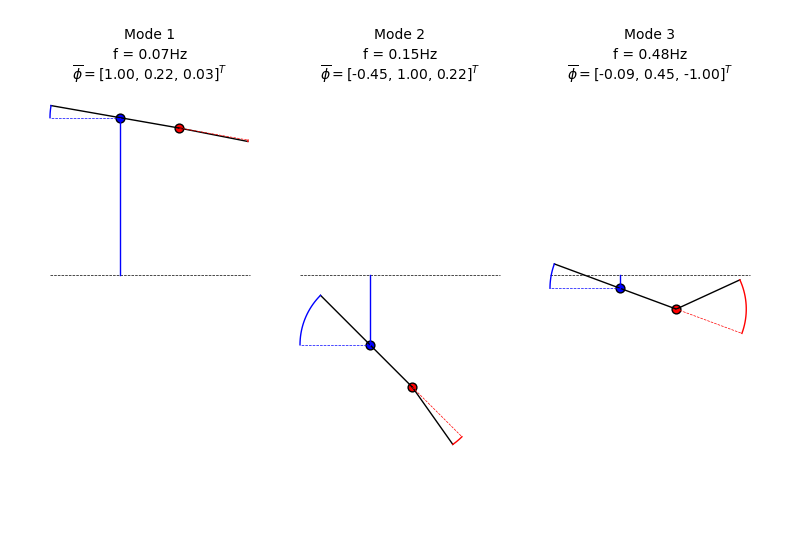

GridspecLayout(children=(FloatSlider(value=-0.3, description='$\\alpha$', layout=Layout(grid_area='widget001',…

In [16]:
# Link sliders with update function
listSliders = [slider_a, slider_CGa, slider_c, slider_CGf,
               slider_b, slider_Kh, slider_Kth, slider_Kb, 
               slider_ma, slider_mf, slider_Iaf, slider_If]

for s in listSliders:
    s.observe(update_modeGraph, names = 'value')

# Display sliders in two columns
gridSliders3 = wgt.GridspecLayout(6, 2, layout = wgt.Layout(width = '1000px'))

gridSliders3[0, 0] = slider_a_3
gridSliders3[1, 0] = slider_CGa_3
gridSliders3[0, 1] = slider_c_3
gridSliders3[1, 1] = slider_CGf_3


gridSliders3[2, 0] = slider_ma_3
gridSliders3[3, 0] = slider_mf_3
gridSliders3[4, 0] = slider_Iaf_3
gridSliders3[5, 0] = slider_If_3

gridSliders3[2, 1] = slider_b_3
gridSliders3[3, 1] = slider_Kh_3
gridSliders3[4, 1] = slider_Kth_3
gridSliders3[5, 1] = slider_Kb_3

# Start by plotting graph
fig2.tight_layout();
plt.show()

display(gridSliders3)

# Static Aeroelasticity

## Steady Aerodynamic Force

In [17]:
# Initialise the global variables
mat_aeroStiff = None

vec_aeroForce_ao = None
vec_aeroForce_bo = None
vec_aeroForce_Cmac = None

# Define a function that takes the slider values and calculates the steady aerodynamics terms
def steadyAeroTerms(a, c, b, q):

    # Calculate flap constants
    T10 = np.sqrt(1 - c**2) + np.arccos(c)
    T12 = np.sqrt(1 - c**2)*(2 + c) - (2*c + 1)*np.arccos(c)
    
    # Aerodynamic stiffness matrix
    mat_aeroStiff = (q*2*b)*np.array([[0, -2*np.pi, -2*T10],
                              [0, 2*np.pi*(0.5 + a)*b, 2*T10*(0.5 + a)*b],
                              [0, -T12*b, -T12*b*T10/np.pi]])
    
    # Aerodynamic force components
    vec_aeroForce_ao = (q*2*b)*np.array([[-2*np.pi], [2*np.pi*(0.5 + a)*b], [-T12*b]])
    vec_aeroForce_bo = (q*2*b*T10/np.pi)*np.array([[-2*np.pi], [2*np.pi*(0.5 + a)*b], [-T12*b]])
    vec_aeroForce_Cmac = np.array([[0], [q*(2*b)*b], [0]])

    # Account for sensitivity of Cmac to beta
    Cl_a = 2*np.pi # in accordance with flat plate assumption
    Cl_b = Cl_a*T10/np.pi
    Cmac_b = 2*(-0.2/1.5)*Cl_b # based on Georgopoulos et al. (2026) JIMSS

    mat_aeroStiff[1, 2] = mat_aeroStiff[1, 2] + q*(2*b)*b*Cmac_b # add this term to the contribution of lift from flap
    vec_aeroForce_bo[1, 0] = vec_aeroForce_bo[1, 0] + q*(2*b)*b*Cmac_b

    return mat_aeroStiff, vec_aeroForce_ao, vec_aeroForce_bo, vec_aeroForce_Cmac

# Define a function that rebuilds the matrices according to changing slider values and re-renders them as Markdown
def update_steadyAeroTerms(change = None):

    global mat_aeroStiff, vec_aeroForce_ao, vec_aeroForce_bo, vec_aeroForce_Cmac

    # Adapt variables based on sliders
    a = slider_a.value
    c = slider_c.value
    b = slider_b.value
    q = slider_q.value

    # Calculate steady aerodynamics terms
    mat_aeroStiff, vec_aeroForce_ao, vec_aeroForce_bo, vec_aeroForce_Cmac = steadyAeroTerms(a, c, b, q)

    # Write output into the Output widget
    with out_steadyAeroTerms:
        
        # Remove the previous matrix so outputs don't stack
        out_steadyAeroTerms.clear_output()
    
        # Display a Markdown cell containing LaTeX
        display(Markdown(textwrap.dedent(f"""
            $$
            \\overline{{f_a}} =
            \\begin{{bmatrix}}
            {mat_aeroStiff[0, 0]:.2f} & {mat_aeroStiff[0, 1]:.2f} & {mat_aeroStiff[0, 2]:.2f} \\\\
            {mat_aeroStiff[1, 0]:.2f} & {mat_aeroStiff[1, 1]:.2f} & {mat_aeroStiff[1, 2]:.2f} \\\\
            {mat_aeroStiff[2, 0]:.2f} & {mat_aeroStiff[2, 1]:.2f} & {mat_aeroStiff[2, 2]:.2f}
            \\end{{bmatrix}}
            \\begin{{bmatrix}}
            h \\\\ \\theta \\\\ \\beta
            \\end{{bmatrix}} + 
            \\begin{{bmatrix}}
            {vec_aeroForce_ao[0, 0]:.2f} \\\\
            {vec_aeroForce_ao[1, 0]:.2f} \\\\
            {vec_aeroForce_ao[2, 0]:.2f}
            \\end{{bmatrix}} \\alpha_o + 
            \\begin{{bmatrix}}
            {vec_aeroForce_bo[0, 0]:.2f} \\\\
            {vec_aeroForce_bo[1, 0]:.2f} \\\\
            {vec_aeroForce_bo[2, 0]:.2f}
            \\end{{bmatrix}} \\beta_o + 
            \\begin{{bmatrix}}
            {vec_aeroForce_Cmac[0, 0]:.2f} \\\\
            {vec_aeroForce_Cmac[1, 0]:.2f} \\\\
            {vec_aeroForce_Cmac[2, 0]:.2f}
            \\end{{bmatrix}} C_{{mac}}
            $$
        """)))

In [18]:
# Define new slider for dynamic pressure
slider_q = wgt.FloatSlider(value = 1.00, min = 0, max = 5, step = 0.1, 
                           style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                           description = '$q [N/m^2]$') # free stream dynamic pressure - [N/m^2]

# Define copy-sliders
slider_a_4, link_a_4 = copySlider(slider_a)
slider_c_4, link_c_4 = copySlider(slider_c)
slider_b_4, link_b_4 = copySlider(slider_b)

# Link sliders with update function
listSliders = [slider_a, slider_c, slider_b, slider_q]

for s in listSliders:
    s.observe(update_steadyAeroTerms, names = 'value')

out_steadyAeroTerms = wgt.Output()
display(out_steadyAeroTerms)

# Display sliders in two columns
gridSliders4 = wgt.GridspecLayout(2, 2, layout = wgt.Layout(width = '1000px'))

gridSliders4[0, 0] = slider_a_4
gridSliders4[1, 0] = slider_c_4

gridSliders4[0, 1] = slider_b_4
gridSliders4[1, 1] = slider_q


display(gridSliders4)

# Initialise markdown cell with matrices
update_steadyAeroTerms()

Output()

GridspecLayout(children=(FloatSlider(value=-0.3, description='$\\alpha$', layout=Layout(grid_area='widget001',…

## Static Aeroelastic Response and Phenomena

In [19]:
# Generate the plot
plt.ioff()
fig3, ax3 = plt.subplots(1, 2, figsize = (8, 5));
fig3.subplots_adjust(wspace = 0.5);
ax3a, ax3b = ax3;

# Format each subplot individually
ax3a.axis("equal"); ax3a.axis("off");
ax3a.plot(np.array([0, 1]), np.array([0, 0]), color = 'black', linewidth = 0.5, linestyle = '--');

ax3b.set_xlabel("Dynamic pressure"); ax3b.set_ylabel("Control effectiveness");
ax3b.set_xticks([]); ax3b.set_yticks([]);
ax3b.axhline(0, color = "black", linewidth = 0.5); ax3b.axvline(0, color = "black", linewidth = 0.5);
ax3b.set_xlim([0, 1.1]); ax3b.set_ylim([-2, 2]);
ax3b.set_frame_on(False)

ax3b.axvline(1, color = "black", linewidth = 0.5, linestyle = '--');
ax3b.text(1.1, 1.9, "$q_{div}$", ha = 'center', va = 'center', color = 'black');


In [20]:
# Function to calculate static aeroelastic response and phenomena
def staticAeroelasticity(a, c, b, q, Kh, Kth, Kb, alpha_o, beta_o, Cmac, n):

    # Assemble structural stiffness matrix
    mat_strStiff = np.array([[Kh, 0, 0],
                             [0, Kth, 0],
                             [0, 0, Kb]])

    # Calculate steady aero forces - careful! unit dynamic pressure here!
    mat_aeroStiff, vec_aeroForce_ao, vec_aeroForce_bo, vec_aeroForce_Cmac = steadyAeroTerms(a, c, b, q = 1)

    # Calculate divergence speed, reversal speed
    Cl_a = 2*np.pi # in accordance with flat plate assumption
    T10 = np.sqrt(1 - c**2) + np.arccos(c) # in accordance with flat plate assumption (Theodorsen expressions)
    Cl_b = Cl_a*T10/np.pi
    Cmac_b = 2*(-0.2/1.5)*Cl_b # based on Georgopoulos et al. (2026) JIMSS
    
    q_div = Kth/(Cl_a*(0.5 + a)*b*(2*b))
    q_rev = -Cl_b*Kth/(Cl_a*(2*b)*b*Cmac_b)

    # Calculate control effectiveness
    contEff = 1 + q*(Cl_a/Cl_b)*2*b*(Cl_b*(0.5 + a)*b + Cmac_b*b)/(Kth - q*2*b*Cl_a*(0.5 + a)*b) # at a given q

    arr_q = np.linspace(0, q_div, n)
    arr_contEff = 1 + arr_q*(Cl_a/Cl_b)*2*b*(Cl_b*(0.5 + a)*b + Cmac_b*b)/(Kth - arr_q*2*b*Cl_a*(0.5 + a)*b)

    # Calculate static aeroelastic response
    alpha_o = alpha_o*np.pi/180; beta_o = beta_o*np.pi/180; # convert from degrees to rad
    
    vec_fext = q*(vec_aeroForce_ao*alpha_o + vec_aeroForce_bo*beta_o + vec_aeroForce_Cmac*Cmac)
    mat_invAE = np.linalg.inv(mat_strStiff - q*mat_aeroStiff)
    
    vec_x = np.dot(mat_invAE, vec_fext)
    vec_f = np.dot(q*mat_aeroStiff, vec_x) + vec_fext

    return vec_x, vec_f, q_div, q_rev, contEff, arr_q, arr_contEff
    

In [21]:
# Initial values to initialise the graph
h_init = 0.4; theta_init = 5; beta_init = 3;
a = slider_a.value
c = slider_c.value

# Prepare struct with graph 1 objects
structFigStAE1 = defineStruct()

# Get key coordinates for initial airfoil and define initial line objects
secPoints = calcSectionPoints_v2(a, c, 0, theta_init*np.pi/180, beta_init*np.pi/180, x_offset = 0.0)

structFigStAE1.line1, = ax3a.plot(secPoints[[3, 4], 0], secPoints[[3, 4], 1], color = 'black', linewidth = 0.5);
structFigStAE1.line2, = ax3a.plot(secPoints[[4, 6], 0], secPoints[[4, 6], 1], color = 'black', linewidth = 0.5);
structFigStAE1.line3, = ax3a.plot(secPoints[[4, 5], 0], secPoints[[4, 5], 1], color = 'black', linewidth = 0.5, linestyle = '--');

# Get key coordinates for displaced airfoil and define displaced line objects
secPoints = calcSectionPoints_v2(a, c, h_init, theta_init*np.pi/180, beta_init*np.pi/180, x_offset = 0.0)

structFigStAE1.line4, = ax3a.plot(secPoints[[3, 4], 0], secPoints[[3, 4], 1], color = 'black', linewidth = 1.0);
structFigStAE1.line5, = ax3a.plot(secPoints[[4, 6], 0], secPoints[[4, 6], 1], color = 'black', linewidth = 1.0);

structFigStAE1.point6 = ax3a.scatter(secPoints[1, 0], secPoints[1, 1], s = 40, c = 'blue', marker = 'o', edgecolor = 'black');
structFigStAE1.point7 = ax3a.scatter(secPoints[4, 0], secPoints[4, 1], s = 40, c = 'red', marker = 'o', edgecolor = 'black');

structFigStAE1.line8, = ax3a.plot(secPoints[[1, 2], 0], secPoints[[1, 2], 1], color = 'blue', linewidth = 0.5, linestyle = '--');
structFigStAE1.line9, = ax3a.plot(secPoints[[4, 5], 0], secPoints[[4, 5], 1], color = 'red', linewidth = 0.5, linestyle = '--');

structFigStAE1.line10, = ax3a.plot(secPoints[[0, 1], 0], secPoints[[0, 1], 1], color = 'blue', linewidth = 1);

# Get arcs for rotational DoF
x_arc1, y_arc1 = calcArcPoints(secPoints[1, :], secPoints[2, :], secPoints[3, :], theta_init*np.pi/180, n = 20) # theta
structFigStAE1.line11, = ax3a.plot(x_arc1, y_arc1, color = 'blue', linewidth = 1);

x_arc2, y_arc2 = calcArcPoints(secPoints[4, :], secPoints[5, :], secPoints[6, :], beta_init*np.pi/180, n = 20) # beta
structFigStAE1.line12, = ax3a.plot(x_arc2, y_arc2, color = 'red', linewidth = 1);

# Get text displaying the user inputs as well as the resulting displacement and aerodynamic force
str_txt13 = "$Inputs: q = $" + str(0) + "$N/m^2, \\alpha_o = $" + str(theta_init) + "$^o, \\beta_o = $" + str(beta_init) + "$^o, C_{mac} = $" + f"{0:.2f}"
structFigStAE1.txt13 = ax3a.text(0.5, 1.2, str_txt13, ha = 'center', va = 'center', color = 'black');

str_txt14 = "$\\overline{{x}} = [h = $" + f"{-h_init:.2f}" + "$m, \\theta = $" + f"{theta_init:.2f}" + "$^o, \\beta = $" + f"{beta_init:.2f}" + "$^o]^T$"
structFigStAE1.txt14 = ax3a.text(0.5, 1.1, str_txt14, ha = 'center', va = 'center', color = 'black');

str_txt15 = "$\\overline{{f_a}} = [L = $" + f"{0:.2f}" + "$N, M_{\\alpha} = $" + f"{0:.2f}" + "$Nm, M_{\\beta} = $" + f"{0:.2f}" + "$Nm]^T$"
structFigStAE1.txt15 = ax3a.text(0.5, 1.0, str_txt15, ha = 'center', va = 'center', color = 'black');

# Prepare struct with graph 2 objects
structFigStAE2 = defineStruct()

n = 40
arr_q = np.linspace(0, 1, n)
arr_Ceff = 1*np.linspace(1, 1, n)

structFigStAE2.line1, = ax3b.plot(arr_q, arr_Ceff, color = 'blue', linewidth = 1);
structFigStAE2.point2 = ax3b.scatter(0.5, 1, s = 40, c = 'red', marker = 'o', edgecolor = 'black');

structFigStAE2.txt3 = ax3b.text(0.55, 2.0, "$C_{eff} = $" + f"{0:.2f}", ha = 'center', va = 'center', color = 'black');
structFigStAE2.txt4 = ax3b.text(0.55, 1.8, "$q_{div} = $" + f"{0:.2f}" + "$N/m^2$", ha = 'center', va = 'center', color = 'black');
structFigStAE2.txt5 = ax3b.text(0.55, 1.6, "$q_{rev} = $" + f"{0:.2f}" + "$N/m^2$", ha = 'center', va = 'center', color = 'black');

In [22]:
# Function that updates the static aeroelasticity graph
def update_staticAEgraph(change):

    # Adapt variables based on sliders
    a = slider_a.value
    c = slider_c.value
    b = slider_b.value
    q = slider_q.value

    Kh = slider_Kh.value
    Kth = slider_Kth.value
    Kb = slider_Kb.value

    alpha_o = slider_alpha_o.value
    beta_o = slider_beta_o.value
    Cmac = slider_Cmac.value

    n = 40 
    vec_x, vec_f, q_div, q_rev, Ceff, arr_q, arr_Ceff = staticAeroelasticity(a, c, b, q, 
                                                                Kh, Kth, Kb, alpha_o, beta_o, Cmac, n)

    # Graph 1
    
    # Get key coordinates for initial airfoil and update initial line objects
    secPoints = calcSectionPoints_v2(a, c, 0, alpha_o*np.pi/180, beta_o*np.pi/180, x_offset = 0.0)

    structFigStAE1.line1.set_xdata(secPoints[[3, 4], 0]); structFigStAE1.line1.set_ydata(secPoints[[3, 4], 1]);
    structFigStAE1.line1.figure.canvas.draw_idle()

    structFigStAE1.line2.set_xdata(secPoints[[4, 6], 0]); structFigStAE1.line2.set_ydata(secPoints[[4, 6], 1]);
    structFigStAE1.line2.figure.canvas.draw_idle()

    structFigStAE1.line3.set_xdata(secPoints[[4, 5], 0]); structFigStAE1.line3.set_ydata(secPoints[[4, 5], 1]);
    structFigStAE1.line3.figure.canvas.draw_idle()
    
    # Get key coordinates for displaced airfoil and update displaced line objects
    secPoints = calcSectionPoints_v2(a, c, -vec_x[0, 0]/(2*b), alpha_o*np.pi/180 + vec_x[1, 0],
                                     beta_o*np.pi/180 + vec_x[2, 0], x_offset = 0.0)

    structFigStAE1.line4.set_xdata(secPoints[[3, 4], 0]); structFigStAE1.line4.set_ydata(secPoints[[3, 4], 1]);
    structFigStAE1.line4.figure.canvas.draw_idle()

    structFigStAE1.line5.set_xdata(secPoints[[4, 6], 0]); structFigStAE1.line5.set_ydata(secPoints[[4, 6], 1]);
    structFigStAE1.line5.figure.canvas.draw_idle()

    structFigStAE1.point6.set_offsets(np.c_[secPoints[1, 0], secPoints[1, 1]])
    structFigStAE1.point6.figure.canvas.draw_idle()

    structFigStAE1.point7.set_offsets(np.c_[secPoints[4, 0], secPoints[4, 1]])
    structFigStAE1.point7.figure.canvas.draw_idle()

    structFigStAE1.line8.set_xdata(secPoints[[1, 2], 0]); structFigStAE1.line8.set_ydata(secPoints[[1, 2], 1]);
    structFigStAE1.line8.figure.canvas.draw_idle()

    structFigStAE1.line9.set_xdata(secPoints[[4, 5], 0]); structFigStAE1.line9.set_ydata(secPoints[[4, 5], 1]);
    structFigStAE1.line9.figure.canvas.draw_idle()

    structFigStAE1.line10.set_xdata(secPoints[[0, 1], 0]); structFigStAE1.line10.set_ydata(secPoints[[0, 1], 1]);
    structFigStAE1.line10.figure.canvas.draw_idle()
    
    # Get arcs for rotational DoF
    x_arc1, y_arc1 = calcArcPoints(secPoints[1, :], secPoints[2, :], secPoints[3, :],
                                   alpha_o*np.pi/180 + vec_x[1, 0], n = 20) # theta
    structFigStAE1.line11.set_xdata(x_arc1); structFigStAE1.line11.set_ydata(y_arc1);
    structFigStAE1.line11.figure.canvas.draw_idle()

    x_arc2, y_arc2 = calcArcPoints(secPoints[4, :], secPoints[5, :], secPoints[6, :],
                                   beta_o*np.pi/180 + vec_x[2, 0], n = 20) # beta
    structFigStAE1.line12.set_xdata(x_arc2); structFigStAE1.line12.set_ydata(y_arc2);
    structFigStAE1.line12.figure.canvas.draw_idle()
    
    # Get text displaying the user inputs as well as the resulting displacement and aerodynamic force
    str_txt13 = "$Inputs: q = $" + f"{q:.2f}" + "$N/m^2, \\alpha_o = $" + f"{alpha_o:.2f}" + "$^o$"
    str_txt13 = str_txt13 + "$, \\beta_o = $" + f"{beta_o:.2f}" + "$^o, C_{mac} = $" + f"{Cmac:.2f}"
    structFigStAE1.txt13.set_text(str_txt13); structFigStAE1.txt13.figure.canvas.draw_idle();

    str_txt14 = "$\\overline{{x}} = [h = $" + f"{vec_x[0, 0]:.2f}" + "$m, \\theta = $" + f"{vec_x[1, 0]*180/np.pi:.2f}" 
    str_txt14 = str_txt14 + "$^o, \\beta = $" + f"{vec_x[2, 0]*180/np.pi:.2f}" + "$^o]^T$"
    structFigStAE1.txt14.set_text(str_txt14); structFigStAE1.txt14.figure.canvas.draw_idle();

    str_txt15 = "$\\overline{{f_a}} = [L = $" + f"{-vec_f[0, 0]:.2f}" + "$N, M_{\\alpha} = $" + f"{vec_f[1, 0]:.2f}" 
    str_txt15 = str_txt15 + "$Nm, M_{\\beta} = $" + f"{vec_f[2, 0]:.2f}" + "$Nm]^T$"
    structFigStAE1.txt15.set_text(str_txt15); structFigStAE1.txt15.figure.canvas.draw_idle();

    # Graph 2

    # Control effectiveness and divergrence speed
    structFigStAE2.line1.set_xdata(arr_q[0:-1]/q_div); structFigStAE2.line1.set_ydata(arr_Ceff[0:-1]);
    structFigStAE2.line1.figure.canvas.draw_idle()

    structFigStAE2.point2.set_offsets(np.c_[q/q_div, Ceff])
    structFigStAE2.point2.figure.canvas.draw_idle()

    str2_txt3 = "$C_{eff} = $" + f"{Ceff:.2f}"
    structFigStAE2.txt3.set_text(str2_txt3); structFigStAE2.txt3.figure.canvas.draw_idle();

    str2_txt4 = "$q_{div} = $" + f"{q_div:.2f}" + "$N/m^2$"
    structFigStAE2.txt4.set_text(str2_txt4); structFigStAE2.txt4.figure.canvas.draw_idle();

    str2_txt5 = "$q_{rev} = $" + f"{q_rev:.2f}" + "$N/m^2$"
    structFigStAE2.txt5.set_text(str2_txt5); structFigStAE2.txt5.figure.canvas.draw_idle();
    

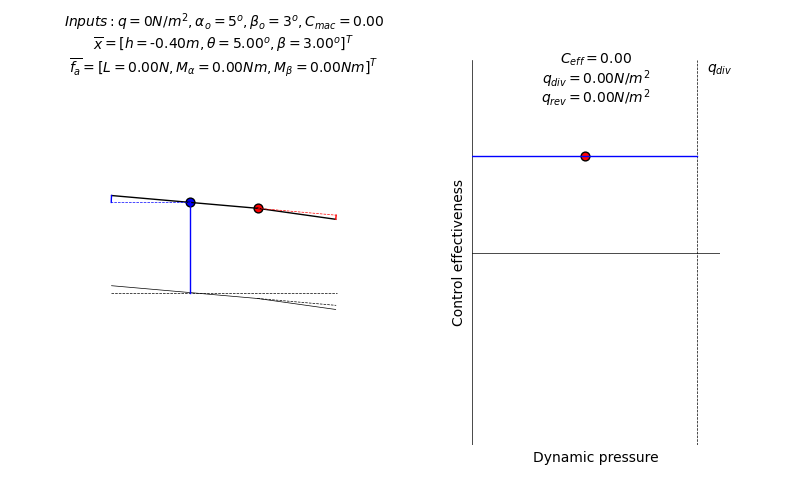

GridspecLayout(children=(FloatSlider(value=-0.3, description='$\\alpha$', layout=Layout(grid_area='widget001',…

In [23]:
# Define new sliders
slider_alpha_o = wgt.FloatSlider(value = 0.00, min = -10, max = 10, step = 0.1, 
                           style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                           description = '$\\alpha_o [^o]$') # rigid angle of attack - [deg]

slider_beta_o = wgt.FloatSlider(value = 0.00, min = -10, max = 10, step = 0.1, 
                           style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                           description = '$\\beta_o [^o]$') # flap deflection angle - [deg]

slider_Cmac = wgt.FloatSlider(value = 0.00, min = -0.20*2, max = 0.20*2, step = 0.01, 
                           style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                           description = '$C_{mac}$') # moment coefficient normalised wrt b (hence the *2 multiplier)

# Define copy-sliders
slider_a_5, link_a_5 = copySlider(slider_a)
slider_c_5, link_c_5 = copySlider(slider_c)
slider_b_5, link_b_5 = copySlider(slider_b)
slider_q_5, link_q_5 = copySlider(slider_q)

slider_Kh_5, link_Kh_5 = copySlider(slider_Kh)
slider_Kth_5, link_Kth_5 = copySlider(slider_Kth)
slider_Kb_5, link_Kb_5 = copySlider(slider_Kb)

# Link sliders with update function
listSliders = [slider_a, slider_c, slider_b, slider_q,
               slider_Kh, slider_Kth, slider_Kb, 
               slider_alpha_o, slider_beta_o, slider_Cmac]

for s in listSliders:
    s.observe(update_staticAEgraph, names = 'value')

# Display sliders in two columns
gridSliders5 = wgt.GridspecLayout(5, 2, layout = wgt.Layout(width = '1000px'))

gridSliders5[0, 0] = slider_a_5
gridSliders5[1, 0] = slider_c_5
gridSliders5[0, 1] = slider_b_5
gridSliders5[1, 1] = slider_q_5


gridSliders5[2, 0] = slider_Kh_5
gridSliders5[3, 0] = slider_Kth_5
gridSliders5[4, 0] = slider_Kb_5

gridSliders5[2, 1] = slider_alpha_o
gridSliders5[3, 1] = slider_beta_o
gridSliders5[4, 1] = slider_Cmac

# Start by plotting graph
# fig3.tight_layout();
plt.show()

display(gridSliders5)